<a href="https://colab.research.google.com/github/balirohan/Human-Emotion-Detection/blob/main/VGG16_for_FER(acu%3D53).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fer2013:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786787%2F1351797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T101053Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D290a21ba7b5dad45573aeab8d61f6e7ed716b1d0251a06b436be3ba270619f9af4d59342bdad89350193c61e9b102cfddbec24026b922fd8aba4573ba18a7eec62f32d0be34573fe6a404a28dbeb9324af979d6d2389ce0ae7b665b859fea92d4901e33e2445950f6be3275befd830ac1dd6b8276b9d54e17459699c6843cbc6960338c362044762485ae790177f50ed04ed876ebcc57dff868e65cd20682478174243aba4f2dc6054c2a2e365a37755ef3483f63065e9426cfa6165aa9ddbbe191bffd197cbd4865381bd28008a21669200d7c6f1fe2bf10b10308fcd7c9ea4636d2ce598c0a79836ef59fbb2bfcd918228a0003e5ca9c2ebb26e655766d115'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 63252113 bytes downloaded
Downloaded and uncompressed: fer2013
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
import tensorflow_addons as tfa

In [ ]:
datagen = ImageDataGenerator(validation_split=0.2)

In [ ]:
train_dataset = datagen.flow_from_directory(
    directory='/kaggle/input/fer2013/train',
    target_size=(48,48),
    class_mode='categorical',
    subset='training',
    batch_size=64
)

Found 22968 images belonging to 7 classes.


In [ ]:
valid_dataset = datagen.flow_from_directory(
    directory='/kaggle/input/fer2013/train',
    target_size=(48,48),
    class_mode='categorical',
    subset='validation',
    batch_size=64
)

Found 5741 images belonging to 7 classes.


In [ ]:
test_dataset = ImageDataGenerator().flow_from_directory(
    directory='/kaggle/input/fer2013/test',
    target_size=(48, 48),
    class_mode='categorical',
    batch_size=64
)

Found 7178 images belonging to 7 classes.


In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [ ]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout_6 (Dropout)         (None, 1, 1, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_8 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 32)                16416     
                                                                 
 batch_normalization_9 (Bat  (None, 32)                128       
 chNormalization)                                     

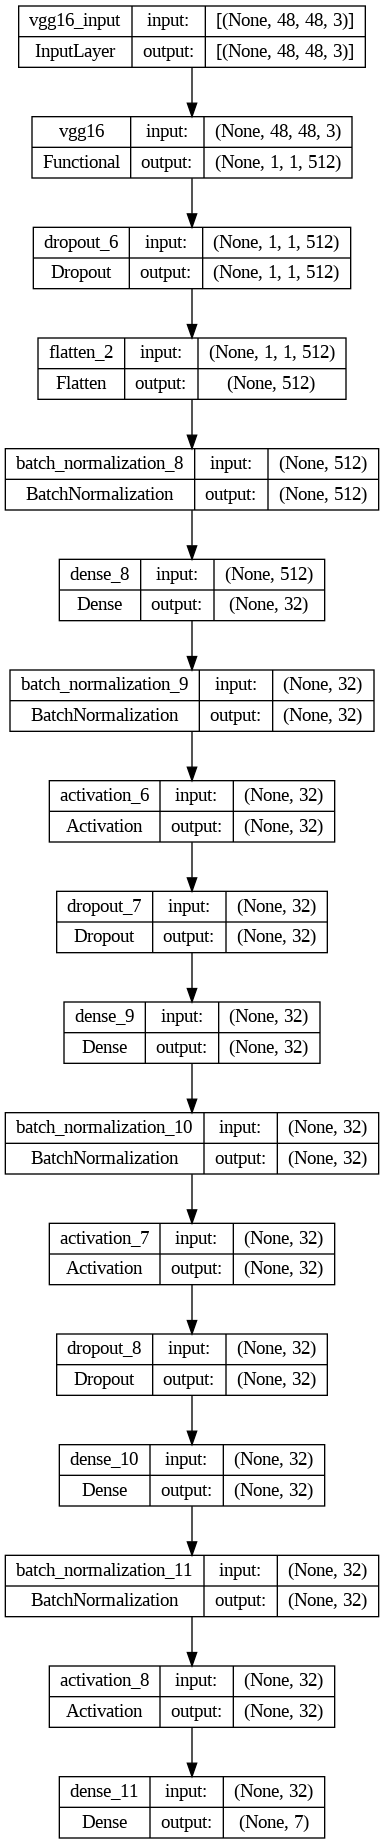

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


In [ ]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=7, name='f1_score')
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 40,verbose = 1,callbacks=[lrd,mcp])

Epoch 1/40
359/359 [==============================] - ETA: 0s - loss: 1.9198 - accuracy: 0.1996 - precision: 0.2248 - recall: 0.0047 - auc: 0.6021 - f1_score: 0.1421

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 30s 51ms/step - loss: 1.9198 - accuracy: 0.1996 - precision: 0.2248 - recall: 0.0047 - auc: 0.6021 - f1_score: 0.1421 - val_loss: 1.8400 - val_accuracy: 0.2440 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6426 - val_f1_score: 0.1300 - lr: 0.0010
Epoch 2/40
359/359 [==============================] - 16s 45ms/step - loss: 1.7794 - accuracy: 0.2520 - precision: 0.3874 - recall: 0.0075 - auc: 0.6744 - f1_score: 0.1446 - val_loss: 1.7738 - val_accuracy: 0.2261 - val_precision: 1.0000 - val_recall: 1.7419e-04 - val_auc: 0.6816 - val_f1_score: 0.0992 - lr: 0.0010
Epoch 3/40
359/359 [==============================] - 16s 43ms/step - loss: 1.7185 - accuracy: 0.2846 - precision: 0.5914 - recall: 0.0246 - auc: 0.7065 - f1_score: 0.1720 - val_loss: 1.8573 - val_accuracy: 0.2235 - val_precision: 0.9412 - val_recall: 0.0028 - val_auc: 0.6834 - val_f1_score: 0.1141 - lr: 0.0010
Epoch 4/40
359/359 [==============================] - 16s 45

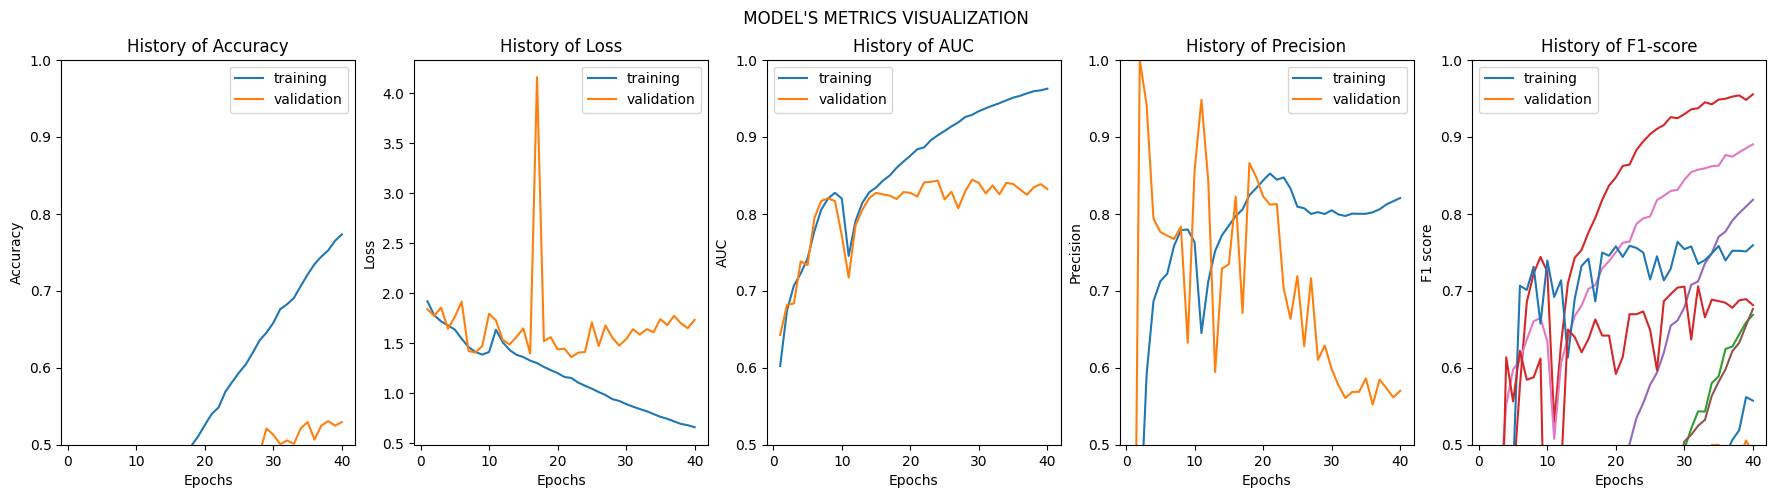

In [ ]:
def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(22, 5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    # Rescale the y-axis for accuracy, auc, precision, and f1
    rescale_factor = 0.5  # Adjust this factor to control the rescaling

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0.5, 1.0])
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.set_ylim([rescale_factor, 1.0])
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.set_ylim([rescale_factor, 1.0])
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.set_ylim([rescale_factor, 1.0])
    ax5.legend(['training', 'validation'])

    plt.show()

# Example usage:
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['f1_score'], history.history['val_f1_score'])


In [ ]:
test_results = model.evaluate(test_dataset)

113/113 [==============================] - 4s 33ms/step - loss: 1.6618 - accuracy: 0.5368 - precision: 0.5750 - recall: 0.4939 - auc: 0.8392 - f1_score: 0.4571


In [ ]:
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = test_dataset.classes

conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

113/113 [==============================] - 4s 31ms/step
Confusion Matrix:
[[121   0  89 199 175 284  90]
 [ 13   0  12  21  17  36  12]
 [113   0  89 201 206 325  90]
 [198   0 185 401 302 537 151]
 [138   0 121 240 229 406  99]
 [147   0 114 286 206 374 120]
 [ 90   0 103 163 161 243  71]]


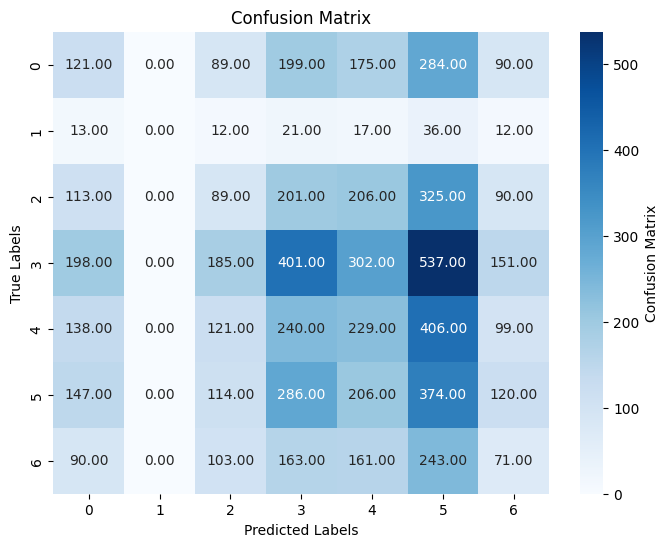

In [ ]:
import seaborn as sns

# # Assuming conf_matrix is the confusion matrix obtained previously
# class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# # Normalize the confusion matrix
# conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# # Create a DataFrame for better visualization
# conf_df = pd.DataFrame(conf_matrix_norm, index=class_names, columns=class_names)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt=".2f", cbar_kws={'label': 'Confusion Matrix'})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       Angry       0.15      0.13      0.14       958
     Disgust       0.00      0.00      0.00       111
        Fear       0.12      0.09      0.10      1024
       Happy       0.27      0.23      0.24      1774
         Sad       0.18      0.19      0.18      1233
    Surprise       0.17      0.30      0.22      1247
     Neutral       0.11      0.09      0.10       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.18      0.18      0.17      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
